In [2]:
print("hedddllo")

hedddllo


In [20]:
import os
import json
from collections import defaultdict

import torch
import clip
from PIL import Image
from tqdm import tqdm


# Ignore warnings
import warnings

In [21]:
import os

current_dir = os.getcwd()
print("Contents of the current working directory: ", current_dir)
for item in os.listdir(current_dir):
    print(item)



Contents of the current working directory:  /data/4wade/nn
data
.venv


In [22]:
import os
import json

# Set paths
data_dir = os.path.join('/data/4wade/nn', 'data')
images_dir = os.path.join(data_dir, 'images')
bboxes_dir = os.path.join(data_dir, 'bounding_boxes')

# Initialize the mapping dictionary
image_to_bbox = {}

# List and sort image files to ensure consistent order
image_files = sorted(f for f in os.listdir(images_dir) if f.endswith('.png'))

for image_file in image_files:
    # Extract image number from filename (e.g., 'img__00001_.png' -> 1)
    try:
        image_num = int(image_file.split('__')[1].split('_')[0])
    except (IndexError, ValueError):
        print(f"Skipping unrecognized image file format: {image_file}")
        continue

    # Adjust for off-by-one indexing
    bbox_num = image_num - 1
    bbox_file = f"bounding_boxes_{bbox_num:05d}.json"

    # Build absolute or relative paths as needed
    image_path = os.path.join('data/images', image_file)
    bbox_path = os.path.join('data/bounding_boxes', bbox_file)

    # Add to mapping
    image_to_bbox[image_path] = bbox_path

imagedirmap = {}
# Optional: Print or save mapping
print("Image to bounding box mapping:")
for img, bbox in image_to_bbox.items():
    # print(f"{img} --> {bbox}")
    imagedirmap[img] = bbox

imagedirmap
# Optional: Save to JSON
# with open('image_bbox_mapping.json', 'w') as f:
#     json.dump(image_to_bbox, f, indent=2)


Image to bounding box mapping:


{'data/images/img__00001_.png': 'data/bounding_boxes/bounding_boxes_00000.json',
 'data/images/img__00002_.png': 'data/bounding_boxes/bounding_boxes_00001.json',
 'data/images/img__00003_.png': 'data/bounding_boxes/bounding_boxes_00002.json',
 'data/images/img__00004_.png': 'data/bounding_boxes/bounding_boxes_00003.json',
 'data/images/img__00005_.png': 'data/bounding_boxes/bounding_boxes_00004.json',
 'data/images/img__00006_.png': 'data/bounding_boxes/bounding_boxes_00005.json',
 'data/images/img__00007_.png': 'data/bounding_boxes/bounding_boxes_00006.json',
 'data/images/img__00008_.png': 'data/bounding_boxes/bounding_boxes_00007.json',
 'data/images/img__00009_.png': 'data/bounding_boxes/bounding_boxes_00008.json',
 'data/images/img__00010_.png': 'data/bounding_boxes/bounding_boxes_00009.json',
 'data/images/img__00011_.png': 'data/bounding_boxes/bounding_boxes_00010.json',
 'data/images/img__00012_.png': 'data/bounding_boxes/bounding_boxes_00011.json',
 'data/images/img__00013_.pn

In [35]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "ViT-B/32"
SIMILARITY_THRESHOLD = 0.15  # tune this on a small validation set

DEVICE

'cuda'

In [36]:
model, preprocess = clip.load(MODEL_NAME, device=DEVICE)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

### Defining classes for the boxes

In [37]:
classes = [
    "knife", "glass", "plate", "bowl", "napkin", "fork",
    "dirty plate", "dirty bowl"
]

### tokanize all classes

In [38]:
text_tokens = clip.tokenize([f"a photo of a {c}" for c in classes]).to(DEVICE)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)            # (N_classes, D)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # normalize

In [39]:
correct_per_image = defaultdict(list)

In [40]:
for img_path, bbox_path in tqdm(imagedirmap.items()):
    img_name = os.path.basename(img_path)
    image = Image.open(img_path).convert("RGB")

    # load the list of boxes
    with open(bbox_path, "r") as f:
        bboxes = json.load(f)

    for box in bboxes:
        ann_label = box["name"]
        # 5.1 Crop & preprocess
        crop = image.crop((box["x1"], box["y1"], box["x2"], box["y2"]))
        image_input = preprocess(crop).unsqueeze(0).to(DEVICE)  # (1,3,224,224)

        # 5.2 Encode with CLIP
        with torch.no_grad():
            img_feat = model.encode_image(image_input)            # (1, D)
            img_feat /= img_feat.norm(dim=-1, keepdim=True)       # normalize

        # 5.3 Compute cosine similarities
        #    (1, D) @ (D, N_classes) → (1, N_classes)
        sims = (img_feat @ text_features.T).squeeze(0)  # → (N_classes,)
        best_idx = sims.argmax().item()
        best_score = sims[best_idx].item()
        predicted = classes[best_idx]

        # 5.4 Check & record
        if (predicted == ann_label) and (best_score >= SIMILARITY_THRESHOLD):
            correct_per_image[img_name].append(ann_label)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.79it/s]


In [41]:
i = 0
for img_name, correct_objs in correct_per_image.items():
    print(f"{img_name}: correct bounding boxes for {correct_objs}")
    i += 1
    if(i == 3):
        break

img__00001_.png: correct bounding boxes for ['fork', 'bowl', 'napkin']
img__00002_.png: correct bounding boxes for ['bowl', 'glass', 'napkin', 'fork']
img__00003_.png: correct bounding boxes for ['bowl', 'napkin']


In [31]:
def display_crops(imagedirmap, max_images=3):
    """
    Display cropped regions for up to max_images images.

    Args:
        imagedirmap (dict): Mapping from image_path to bbox_json_path.
        max_images (int): Maximum number of images to display.
    """
    import json
    import os
    from PIL import Image
    import matplotlib.pyplot as plt

    count = 0
    for img_path, bbox_json in imagedirmap.items():
        if count >= max_images:
            break

        # Load image and bounding-box annotations
        img = Image.open(img_path).convert("RGB")
        with open(bbox_json, 'r') as f:
            bboxes = json.load(f)

        # Determine grid dimensions
        num_boxes = len(bboxes)
        cols = min(num_boxes, 4)
        rows = (num_boxes + cols - 1) // cols

        # Create a matplotlib figure with subplots
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        axes = axes.flatten() if num_boxes > 1 else [axes]

        # Plot each cropped region
        for ax, box in zip(axes, bboxes):
            crop = img.crop((box['x1'], box['y1'], box['x2'], box['y2']))
            ax.imshow(crop)
            ax.set_title(box['name'])
            ax.axis('off')

        # Hide any unused subplots
        for ax in axes[num_boxes:]:
            ax.axis('off')

        plt.suptitle(f"Crops for {os.path.basename(img_path)}")
        plt.tight_layout()
        plt.show()

        count += 1

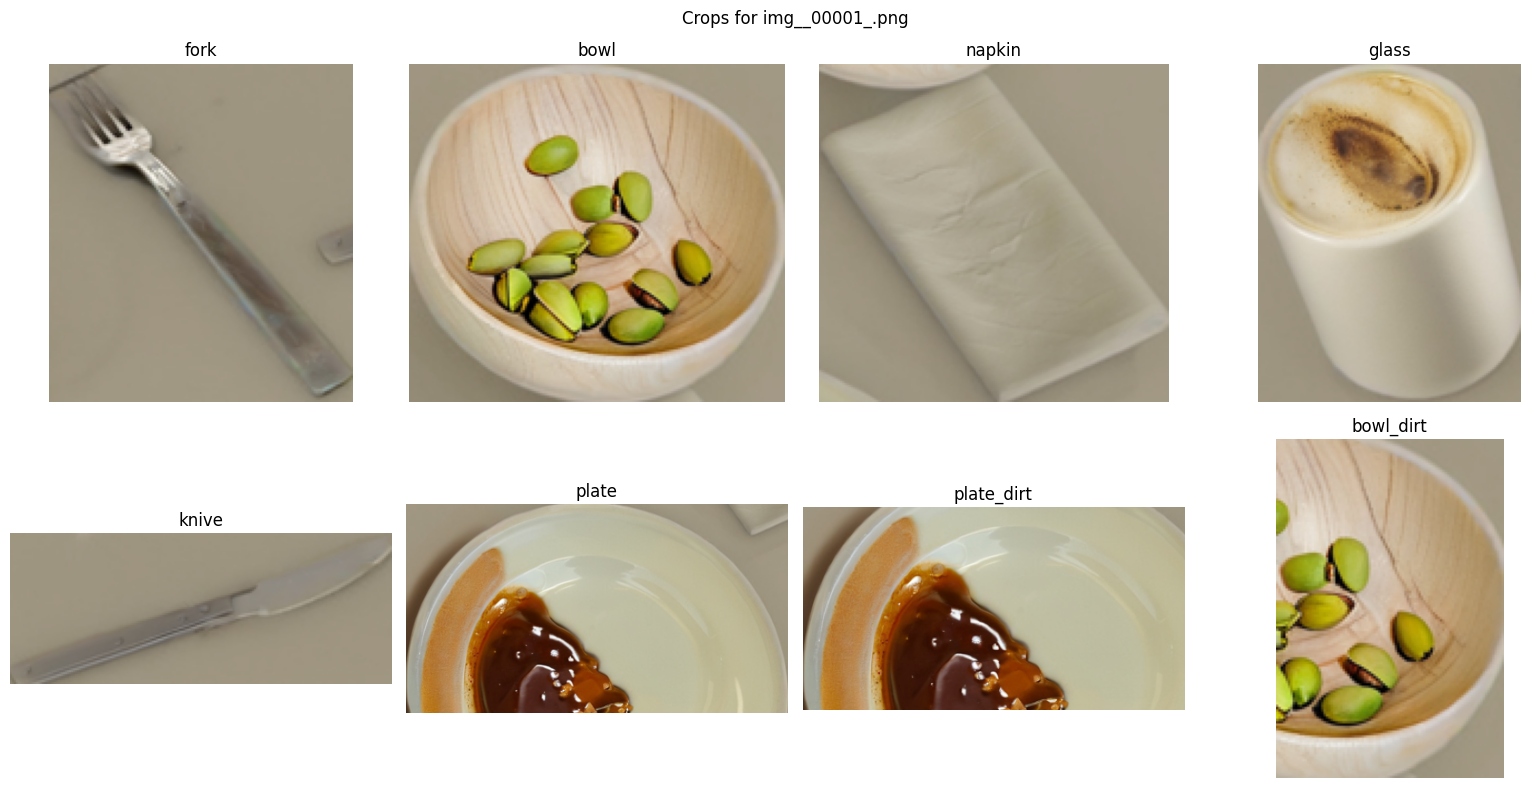

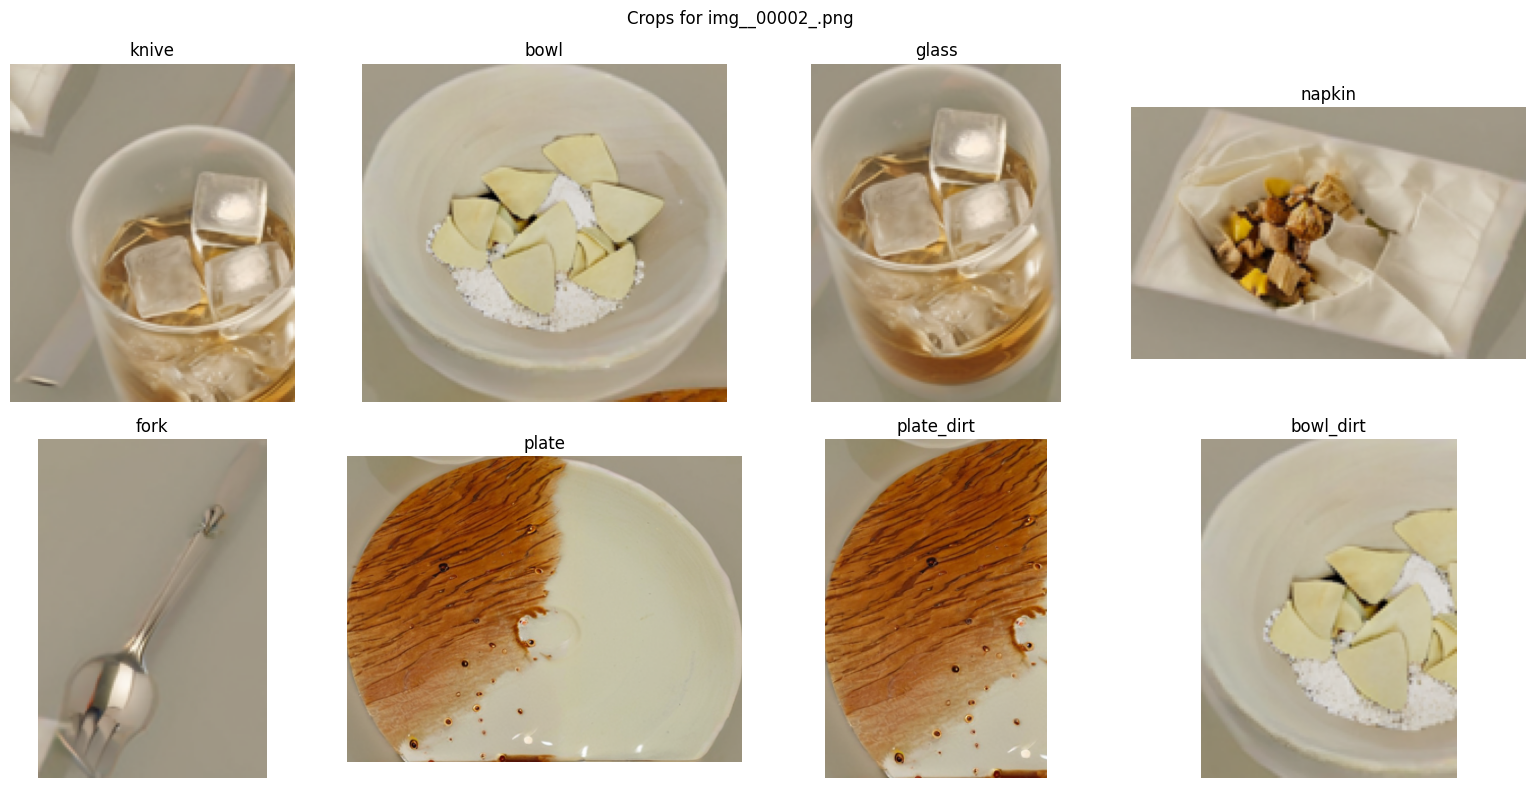

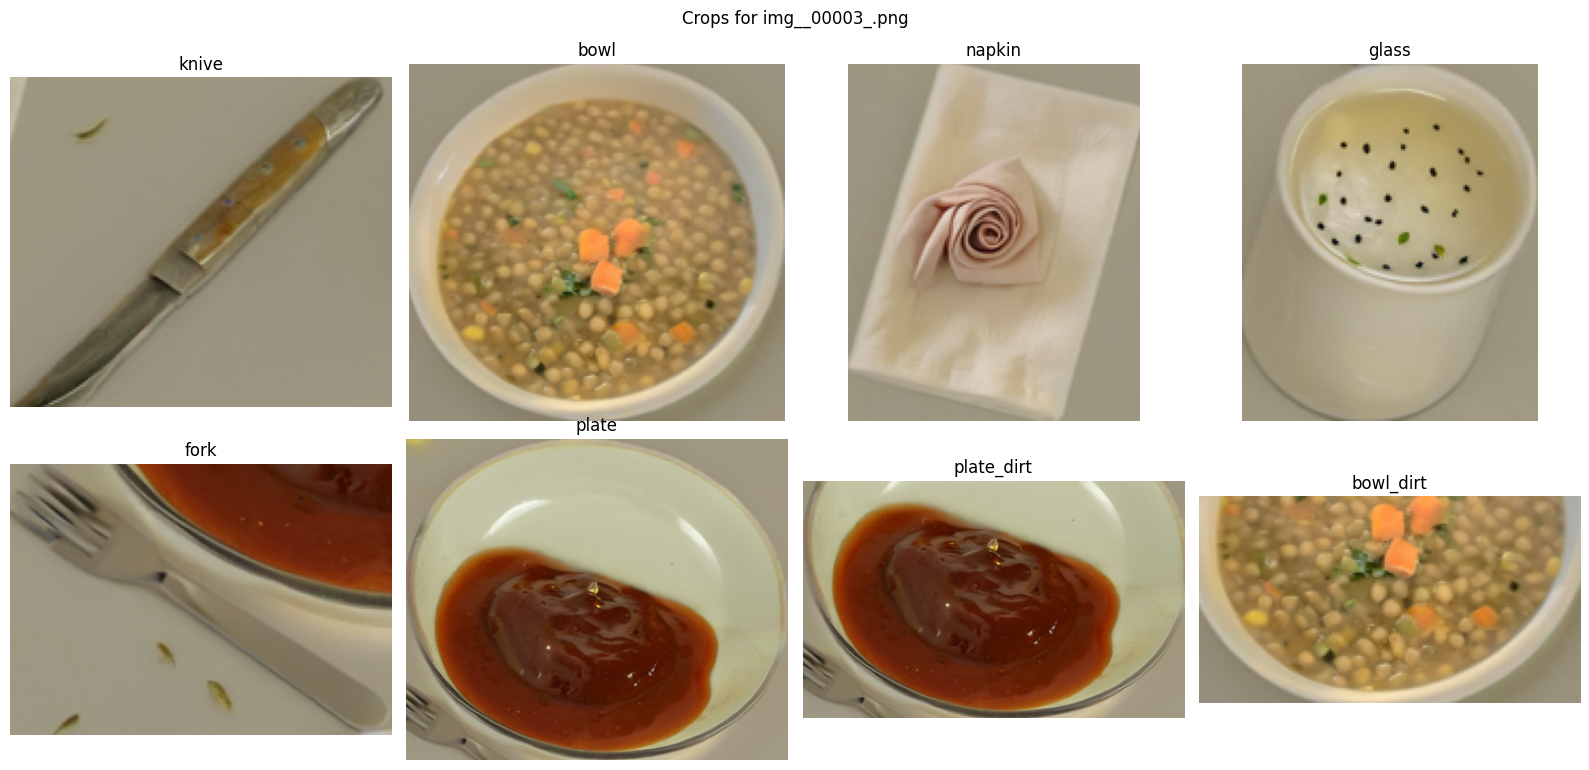

In [32]:
display_crops(imagedirmap)